In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot,abline_plot
import shap
warnings.filterwarnings("ignore")

Importando la data

In [ ]:
data = pd.read_csv("/content/inputcafe.csv",index_col=0)

In [ ]:
data = data[["ASNM","HUMEDAD","PRECIPITACION","PRESION_ATMOSFERICA","TEMPERATURA","TEMPERATURA_MAXIMA","TEMPERATURA_MINIMA","VELOCIDAD_VIENTO","AREA SEMBRADA (HA)","AREA COSECHADA (HA)","PRODUCCION (T)","RENDIMIENTO CALCULADO (T/HA)"]]

Descripción del dataset

In [ ]:
#Dimensión del dataset
print("Shape del dataset",np.shape(data))

Shape del dataset (747, 12)


In [ ]:
#Resumen de estadísticas del dataset
data.describe()

,ASNM,HUMEDAD,PRECIPITACION,PRESION_ATMOSFERICA,TEMPERATURA,TEMPERATURA_MAXIMA,TEMPERATURA_MINIMA,VELOCIDAD_VIENTO,AREA SEMBRADA (HA),AREA COSECHADA (HA),PRODUCCION (T),RENDIMIENTO CALCULADO (T/HA)
count,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1246.129853,77.109970,1954.289106,853.151489,20.076178,32.466908,10.227631,1.947208,2079.750214,1739.799893,1819.054177,1.000140
std,720.029576,13.211870,2633.912753,90.452681,5.316213,6.883943,8.124702,2.132922,2640.751265,2224.512210,2521.341480,0.323572
min,3.000000,0.999613,0.100000,590.478369,0.818269,12.400000,-15.000000,0.228697,1.420000,1.090000,0.990000,0.064639
25%,661.000000,73.643527,630.550000,800.370244,17.006498,28.300000,7.050000,1.234749,304.240000,246.000000,210.000000,0.780888
50%,1278.000000,79.349134,1218.600000,845.385917,20.686871,32.400000,12.200000,1.616168,946.000000,750.000000,730.000000,1.035943
75%,1750.000000,85.067889,2337.200000,909.187392,23.657466,36.900000,15.700000,2.073729,3154.240000,2374.000000,2498.000000,1.203963
max,3203.000000,99.637873,50295.207000,1140.558333,32.535072,50.000000,23.700000,45.767558,14417.000000,11902.000000,18874.000000,3.174757


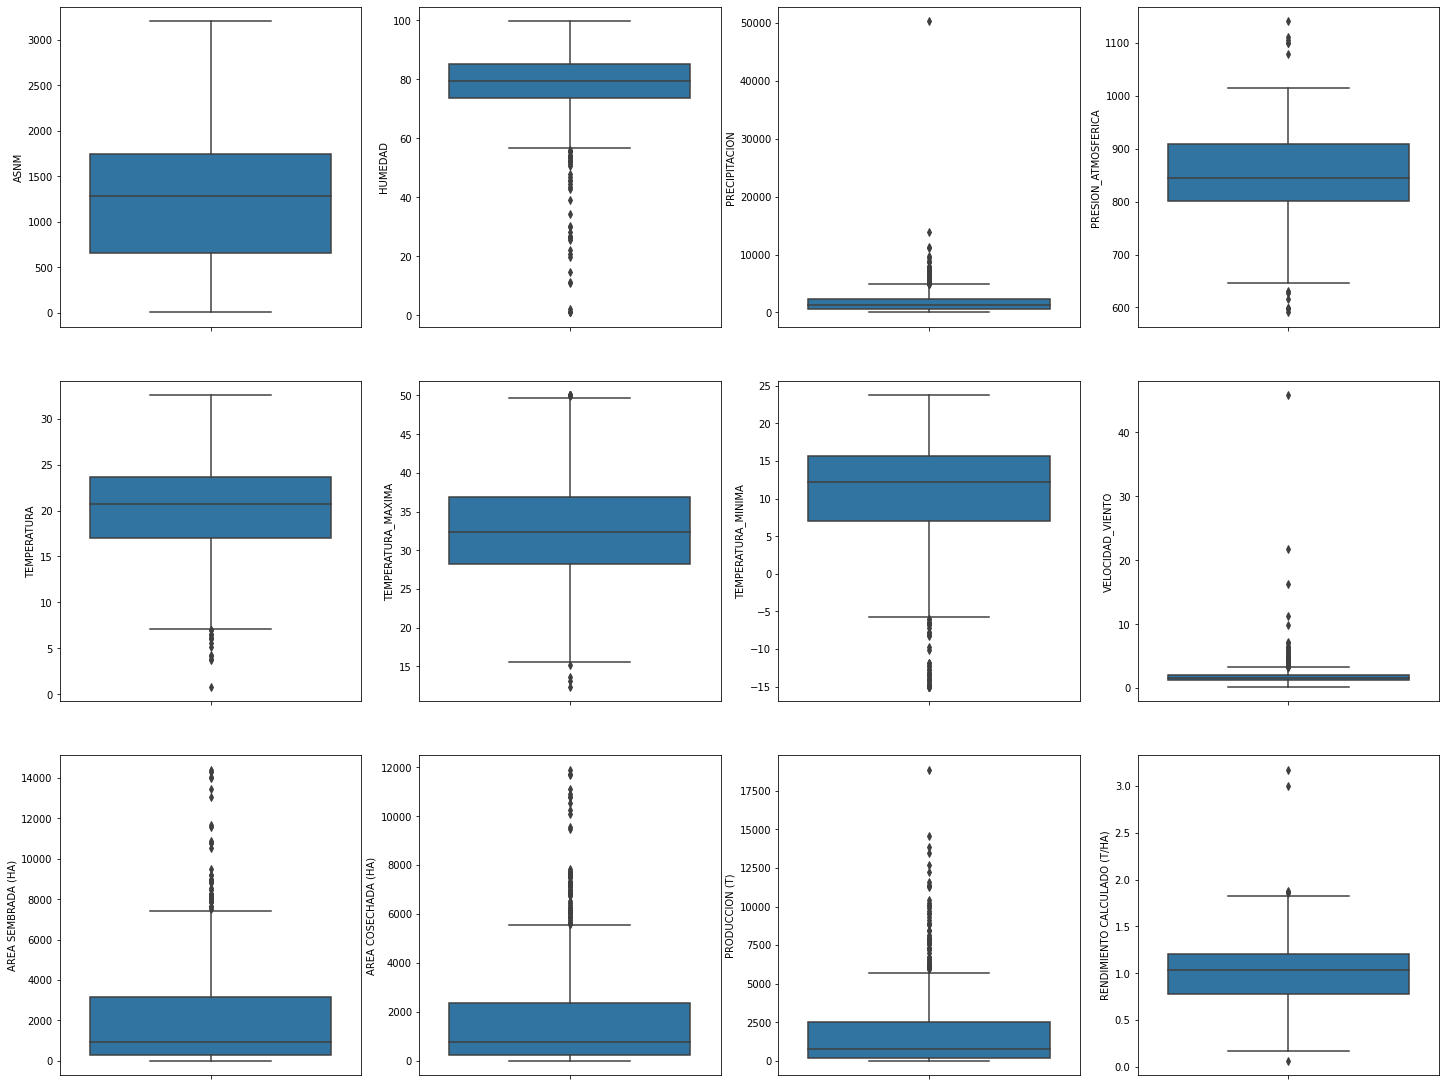

In [ ]:
# BoxPlots del datatset
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# Detectando Outliers utilizando el rango intercuartílico
for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Columna %s outliers = %.2f%%" % (k, perc)) 

Columna ASNM outliers = 0.00%
Columna HUMEDAD outliers = 5.35%
Columna PRECIPITACION outliers = 10.84%
Columna PRESION_ATMOSFERICA outliers = 1.87%
Columna TEMPERATURA outliers = 1.87%
Columna TEMPERATURA_MAXIMA outliers = 1.74%
Columna TEMPERATURA_MINIMA outliers = 5.89%
Columna VELOCIDAD_VIENTO outliers = 9.10%
Columna AREA SEMBRADA (HA) outliers = 5.76%
Columna AREA COSECHADA (HA) outliers = 7.63%
Columna PRODUCCION (T) outliers = 7.50%
Columna RENDIMIENTO CALCULADO (T/HA) outliers = 0.80%


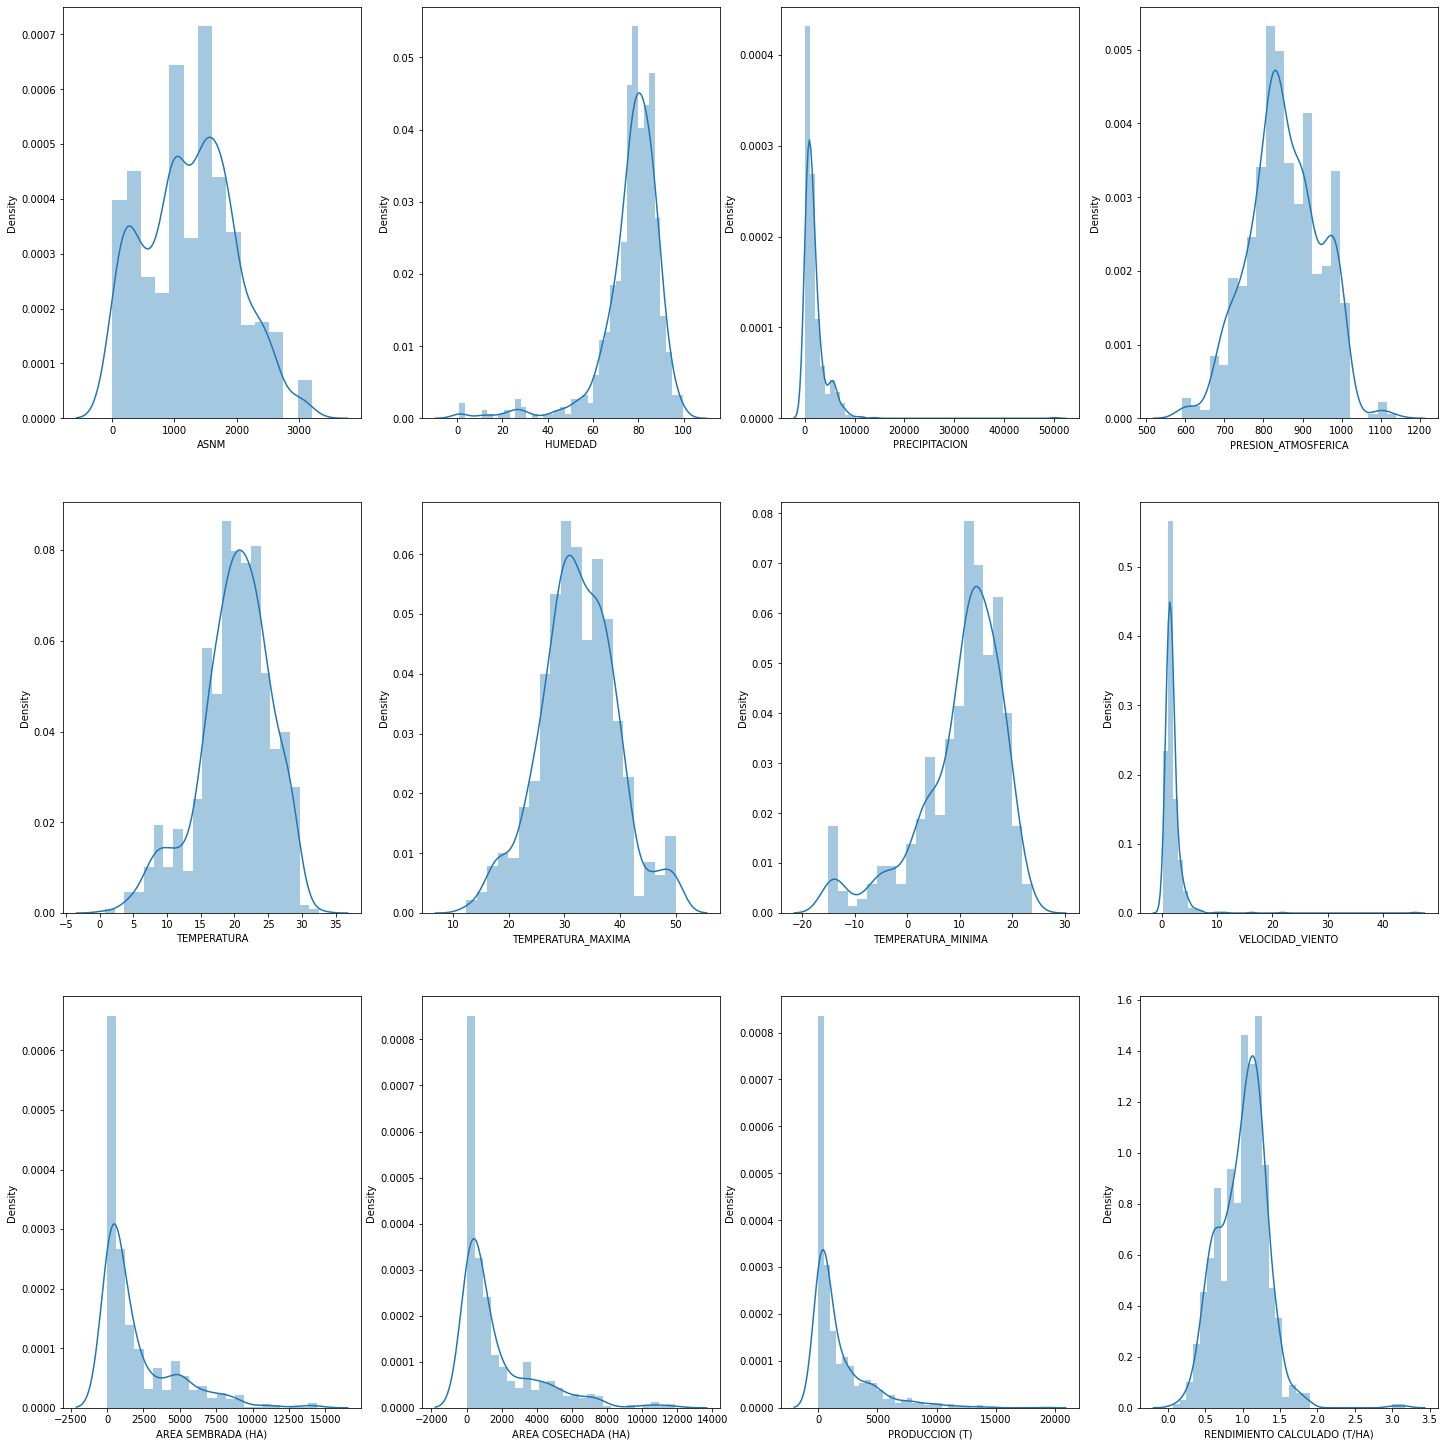

In [ ]:
# Graficando las distribuciones de probabilidad del datatset
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 20))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Los gráficos de histogramas muestran que las columnas HUMEDAD, PRECIPITACION, VELOCIDAD VIENTO tienen distribuciones altamente sesgadas. Las variables AREA COSECHADA (HA) Y PRODUCCION (T) siguen la misma distribución de probabilidad que la variable AREA SEMBRADA lo cual sugiere a priori una alta correlación entre las variables. El RENDIMIENTO (T/HA) parece seguir una distribución normal; otras columnas parecen seguir una distribución normal o multimodal excepto CULTIVO, la cual es una variables binaria.

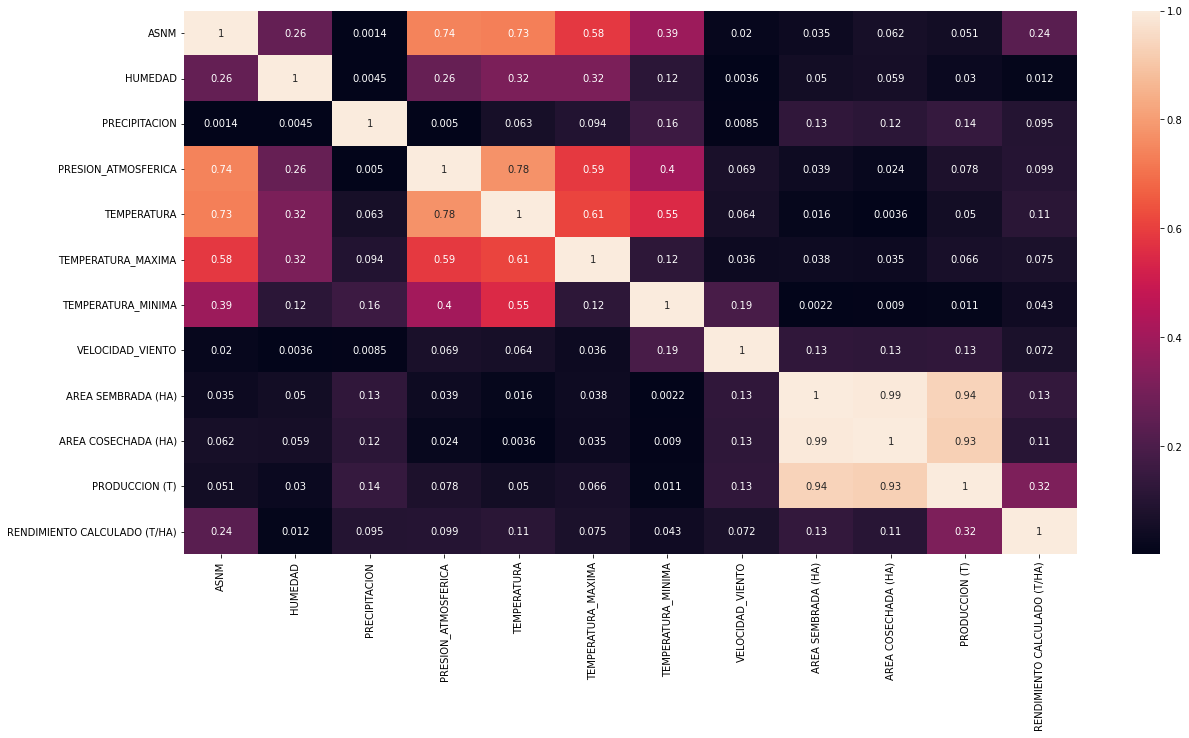

In [ ]:
# Correlación por pares de datos de la totalidad del dataset
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),annot=True)

**Implementación de modelos**

***División del conjunto de datos en Entrenamiento, Validación y Prueba***

In [ ]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Definiendo el dataset de entrada para los modelos
data = data[["ASNM","HUMEDAD","PRECIPITACION","PRESION_ATMOSFERICA","TEMPERATURA","TEMPERATURA_MAXIMA","TEMPERATURA_MINIMA","VELOCIDAD_VIENTO","AREA SEMBRADA (HA)","RENDIMIENTO CALCULADO (T/HA)"]]
columns = data.drop("RENDIMIENTO CALCULADO (T/HA)",axis=1)

In [ ]:
# División del dataset y escalado de datos
X = data.iloc[:, 0:9].values
Y = data.iloc[:, 9].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=False, random_state = 25) #podemos setear el random state a 0
sc_X = StandardScaler()
sc_y = StandardScaler() 
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test) 
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of Y_test",Y_test.shape)

Shape of X_train:  (597, 9)
Shape of X_test:  (150, 9)
Shape of Y_train:  (597, 1)
Shape of Y_test (150, 1)


***Análisis y Reducción de la Dimensionalidad del dataset seleccionado***

***Multicolinealidad***

In [ ]:
# Análisis del VIF para identificar posibles relaciones de dependencia en las variables independientes del conjunto de datos de entrenamiento
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data.iloc[:, 0:9]
vif_data = pd.DataFrame() 
vif_data["Feature"] =X.columns 
vif_data["VIF"] = [variance_inflation_factor(X_train, i) 
                          for i in range(len(X.columns))] 
vif_data

,Feature,VIF
0,ASNM,2.638472
1,HUMEDAD,1.168319
2,PRECIPITACION,1.058136
3,PRESION_ATMOSFERICA,2.797112
4,TEMPERATURA,3.886554
5,TEMPERATURA_MAXIMA,2.091528
6,TEMPERATURA_MINIMA,1.605048
7,VELOCIDAD_VIENTO,1.113500
8,AREA SEMBRADA (HA),1.080888


***Análisis de características significativas usando Backward Elimination***

In [ ]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Utilizando un algoritmo de Randoom Forest para encontrar la mejor combinación de variables
from sklearn.ensemble import RandomForestRegressor
sfs = SFS(RandomForestRegressor(n_jobs=-1,random_state=0), 
          k_features=(1,9), 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,
          )
sfs = sfs.fit(X_train,Y_train)

print('\nCaracterísticas Significativas (índice en el dataframe):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)


Características Significativas (índice en el dataframe):
(0, 2, 3, 4, 5, 7)
CV Score:
-0.09551856297243408


In [ ]:
data.columns

Index(['ASNM', 'HUMEDAD', 'PRECIPITACION', 'PRESION_ATMOSFERICA',
       'TEMPERATURA', 'TEMPERATURA_MAXIMA', 'TEMPERATURA_MINIMA',
       'VELOCIDAD_VIENTO', 'AREA SEMBRADA (HA)',
       'RENDIMIENTO CALCULADO (T/HA)'],
      dtype='object')

La técnica Backward elimination sugiere que las características significativas son la longitud, la altura sobre el nivel del mar, el tipo de cultivo, la dirección del viento, la precipitación acumulada, la temperatura media y el área sembrada.

***Análisis de características significativas usando Sequential Forward Selection***

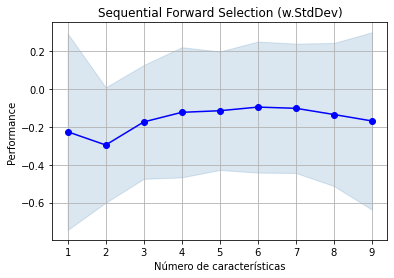

In [ ]:
# Graficando el aporte de las carcaterísticas al performance del modelo, conforme se añade una a una
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.xlabel("Número de características")
plt.ylabel("Performance")
plt.title("Sequential Forward Selection (w.StdDev)")
plt.show()

**Modelos de Machine Learning**

***Regresión Lineal***

In [ ]:
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression(fit_intercept=True,n_jobs=-1).fit(X_train, Y_train)

In [ ]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10

for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    # Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = LinearRegression(fit_intercept=True,n_jobs=-1).fit(X_train, Y_train)

    # Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)
    
    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
    
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)
    
    s = s+1
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [ ]:
# Guardando las repeticiones en un pandas dataframe
metricslr=pd.DataFrame({'cv_lr':CV,
                        'r2_score_lr_train':R2train,
                        'r2_score_lr_test':R2test,
                        'mse_lr':MSE,
                        'rmse_lr':RMSE,
                        'mae_lr':MAE,
                        'mape_lr': MAPE})
metricslr

,cv_lr,r2_score_lr_train,r2_score_lr_test,mse_lr,rmse_lr,mae_lr,mape_lr
0,0.049152,0.107224,0.060766,0.099594,0.315585,0.264239,0.371055
1,-0.005684,0.087956,0.159675,0.084087,0.289978,0.234477,0.289680
2,0.058157,0.103459,0.092375,0.096779,0.311094,0.255054,0.399401
3,0.112953,0.153109,-0.028920,0.124563,0.352934,0.265020,0.352513
4,0.076130,0.112006,0.073398,0.114148,0.337858,0.258423,0.368871
5,0.014734,0.109957,0.074004,0.083000,0.288097,0.236178,0.296885
6,0.054896,0.113903,0.042260,0.091458,0.302421,0.243990,0.329371
7,0.059217,0.110081,0.088368,0.063126,0.251249,0.205048,0.247624
8,0.056516,0.122408,0.067040,0.161124,0.401402,0.286830,0.423331
9,0.111836,0.140975,-0.087622,0.096803,0.311132,0.253580,0.346702


In [ ]:
# Exportando las repeticiones
metricslr.to_csv('repeticiones regresion lineal.csv', encoding = 'utf-8-sig') 
files.download('repeticiones regresion lineal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.1597


<Figure size 432x288 with 0 Axes>

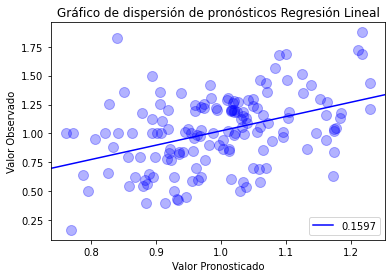

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión Regresión Lineal")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos Regresión Lineal")
plt.legend()
plt.show()

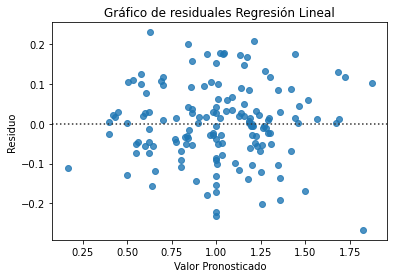

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales Regresión Lineal")
plt.show()

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

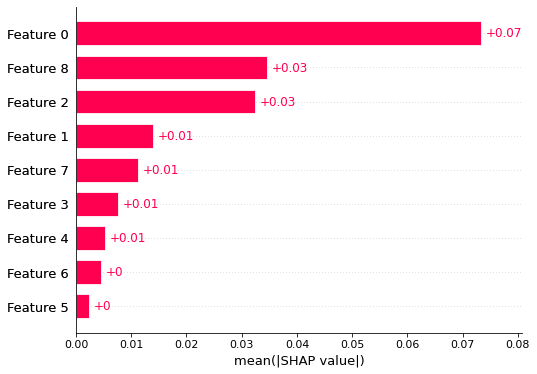

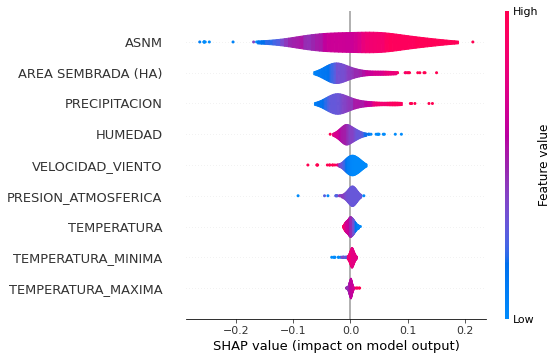

In [ ]:
# Shap Values
explainer = shap.Explainer(regressor, masker=shap.maskers.Impute(data=X_Test),
                            algorithm="linear")
shap_values = explainer(X_Test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values,plot_type='violin',feature_names=columns.columns)

**Decission Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)

In [ ]:
# Encontrando los mejores hiperparámetros para el modelo
# param_grid = { 'min_samples_split':[6,8,10,12],
#               'max_depth'  : [1,10,20],
#               'max_features': ['auto', 'log2','sqrt'], 
#               'max_leaf_nodes': [1,10,20],
#               }
# g_search = GridSearchCV(estimator =regressor_dt, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
# g_search.fit(X_train, Y_train);
# print("Los mejores parámetros son: ","\n", g_search.best_params_)

In [ ]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10

for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = DecisionTreeRegressor(criterion = "squared_error", max_depth = 1, max_features= "auto",max_leaf_nodes=10, min_samples_split=6).fit(X_train, Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)

    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)

    s=s+1

    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [ ]:
# Guardando las repeticiones en un pandas dataframe
metricsdt=pd.DataFrame({'cv_dt':CV,
                        'r2_score_dt_train':R2train,
                        'r2_score_dt_test':R2test,
                        'mse_dt':MSE,
                        'rmse_dt':RMSE,
                        'mae_dt':MAE,
                        'mape_dt': MAPE})
metricsdt

,cv_dt,r2_score_dt_train,r2_score_dt_test,mse_dt,rmse_dt,mae_dt,mape_dt
0,0.050347,0.084560,0.069368,0.098682,0.314137,0.255764,0.367525
1,0.069179,0.091030,0.035130,0.096550,0.310725,0.242721,0.306504
2,0.046750,0.084605,0.013226,0.105219,0.324375,0.259593,0.425023
3,0.090505,0.095384,0.060359,0.113754,0.337275,0.243546,0.345612
4,0.083860,0.096078,0.046333,0.117482,0.342757,0.255583,0.371080
5,0.021710,0.077595,0.079005,0.082552,0.287318,0.226289,0.291667
6,0.041243,0.078739,0.079098,0.087940,0.296548,0.235187,0.328674
7,0.053204,0.086908,0.088062,0.063147,0.251291,0.199159,0.243438
8,0.083389,0.113736,0.048196,0.164378,0.405435,0.295290,0.445388
9,0.100435,0.107272,-0.033656,0.092000,0.303315,0.242383,0.340841


In [ ]:
# Exportando las repeticiones
metricslr.to_csv('repeticiones arbol de decision.csv', encoding = 'utf-8-sig') 
files.download('repeticiones arbol de decision.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.0881


<Figure size 432x288 with 0 Axes>

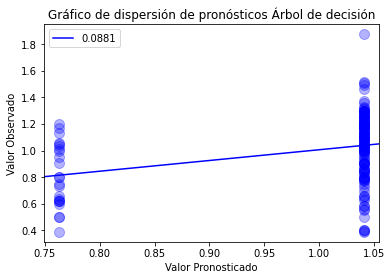

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión ")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos Árbol de decisión")
plt.legend()
plt.show()

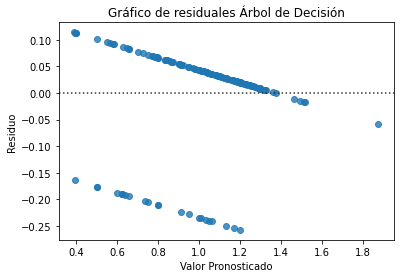

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales Árbol de Decisión")
plt.show()

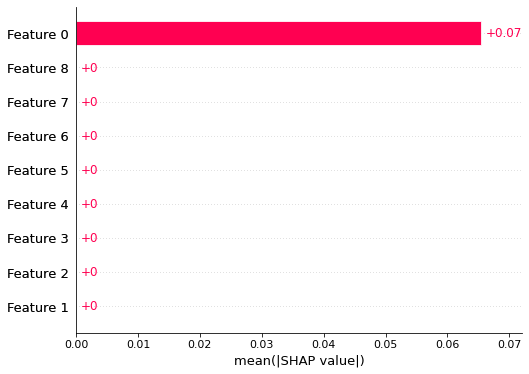

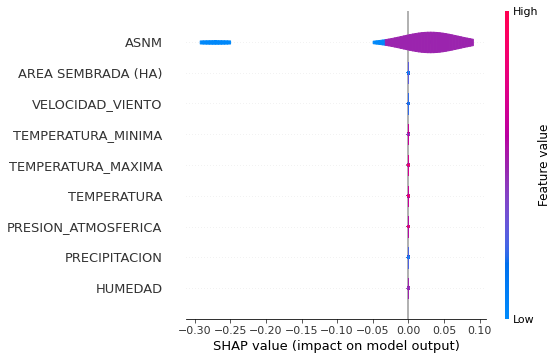

In [ ]:
# Shap Values
explainer = shap.TreeExplainer(regressor, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Extreme Gradient Boosting Regressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
regressor_xgbr=GradientBoostingRegressor(random_state=0)

In [ ]:
# Encontrando los mejores hiperparámetros para el modelo
# param_grid = {'min_samples_split':[2,4,6,8,10],
#               'max_depth'  : [1,10,100,500,1000],
#               'max_features': ['auto', 'log2','sqrt'], 
#               'max_leaf_nodes': [1,10,100,500,1000],
#               'n_estimators': [20,50,100,150],
#               }
# g_search = GridSearchCV(estimator =regressor_xgbr, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
# g_search.fit(X_train, Y_train);
# print("Los mejores parámetros son: ","\n", g_search.best_params_)

In [ ]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10

for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = GradientBoostingRegressor(n_estimators = 20, min_samples_split= 4, max_depth = 100, max_features= 'log2', max_leaf_nodes = 100, random_state = s).fit(X_train , Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)

    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)
   
    s=s+1
   
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [ ]:
# Guardando las repeticiones en un pandas dataframe
metricsxgbr=pd.DataFrame({'cv_xgbr':CV,
                        'r2_score_xgbr_train':R2train,
                        'r2_score_xgbr_test':R2test,
                        'mse_xgbr':MSE,
                        'rmse_xgbr':RMSE,
                        'mae_xgbr':MAE,
                        'mape_xgbr':MAPE})
metricsxgbr

,cv_xgbr,r2_score_xgbr_train,r2_score_xgbr_test,mse_xgbr,rmse_xgbr,mae_xgbr,mape_xgbr
0,0.187387,0.934941,0.089425,0.096555,0.310733,0.253062,0.367169
1,0.178625,0.935990,-0.083977,0.108468,0.329345,0.245464,0.314257
2,0.079556,0.936132,0.052116,0.101072,0.317918,0.248653,0.396252
3,0.283426,0.942826,0.077350,0.111697,0.334212,0.240268,0.325033
4,0.150989,0.938817,0.180022,0.101013,0.317826,0.230953,0.328914
5,0.129383,0.938282,0.148742,0.076301,0.276227,0.219935,0.272155
6,0.177976,0.939089,0.168749,0.079379,0.281744,0.225151,0.303089
7,0.226112,0.936499,-0.072990,0.074299,0.272579,0.204211,0.247754
8,0.281247,0.937058,0.144871,0.147682,0.384294,0.266585,0.403552
9,0.152003,0.938164,0.138664,0.076663,0.276881,0.220838,0.305207


In [ ]:
# Exportando las repeticiones
metricsxgbr.to_csv('repeticiones XGBoost.csv', encoding = 'utf-8-sig') 
files.download('repeticiones XGBoost.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.1800


<Figure size 432x288 with 0 Axes>

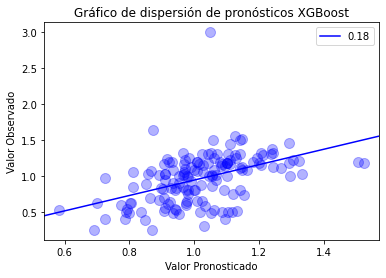

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos XGBoost")
plt.legend()
plt.show()

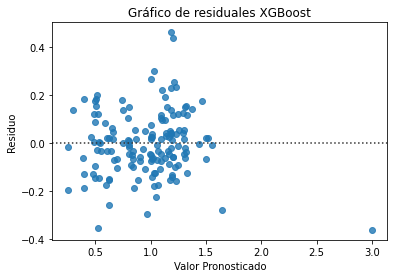

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales XGBoost")
plt.show()

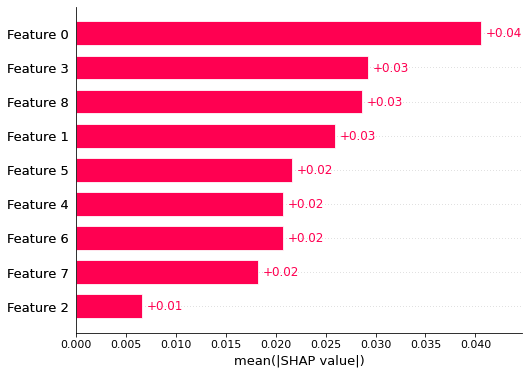

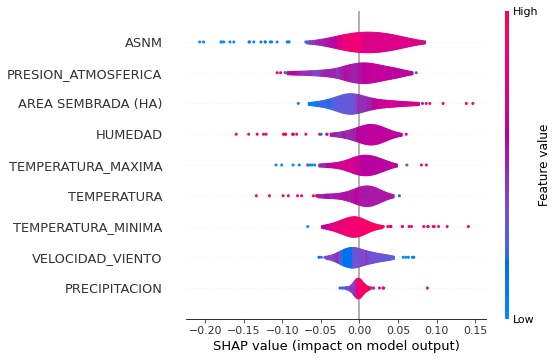

In [ ]:
# Shap Values
explainer = shap.TreeExplainer(regressor, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(random_state = 0)

In [ ]:
# Encontrando los mejores hiperparámetros para el modelo
# param_grid = {'min_samples_split':[2,4,6,8,10],
#               'max_depth'  : [1,10,100,500,1000],
#               'max_features': ['auto', 'log2','sqrt'], 
#               'max_leaf_nodes': [1,10,100,500,1000],
#               'n_estimators': [300,500,800,1000],
#               }
# g_search = GridSearchCV(estimator =regressor_rf, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
# g_search.fit(X_train, Y_train);
# print("Los mejores parámetros son: ","\n", g_search.best_params_)

In [ ]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10

for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = RandomForestRegressor(n_estimators = 300, min_samples_split=8, max_depth = 10, max_features= 'log2', max_leaf_nodes = 100, random_state = 0).fit(X_train, Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)

    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)

    s=s+1
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [ ]:
# Guardando las repeticiones en un pandas dataframe
metricsrf=pd.DataFrame({'cv_rf':CV,
                        'r2_score_rf_train':R2train,
                        'r2_score_rf_test':R2test,
                        'mse_rf':MSE,
                        'rmse_rf':RMSE,
                        'mae_rf':MAE,
                        'mape_rf':MAPE})
metricsrf

,cv_rf,r2_score_rf_train,r2_score_rf_test,mse_rf,rmse_rf,mae_rf,mape_rf
0,0.225716,0.670393,0.214987,0.083241,0.288515,0.233461,0.341059
1,0.198935,0.648985,0.182018,0.081852,0.286097,0.224003,0.287445
2,0.184639,0.668936,0.082094,0.097876,0.312851,0.249450,0.402368
3,0.286731,0.701573,0.078424,0.111567,0.334017,0.241193,0.320286
4,0.228995,0.684898,0.197959,0.098804,0.314330,0.225989,0.326734
5,0.218395,0.667333,0.150095,0.076180,0.276007,0.218243,0.280417
6,0.216732,0.681900,0.176487,0.078641,0.280429,0.225123,0.303771
7,0.227297,0.673167,0.053687,0.065528,0.255984,0.193787,0.244629
8,0.271639,0.693970,0.174723,0.142527,0.377527,0.256650,0.388310
9,0.211794,0.675497,0.141273,0.076431,0.276461,0.223935,0.305860


In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.2150


In [ ]:
metricsrf.to_csv('repeticiones random forest.csv', encoding = 'utf-8-sig') 
files.download('repeticiones random forest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

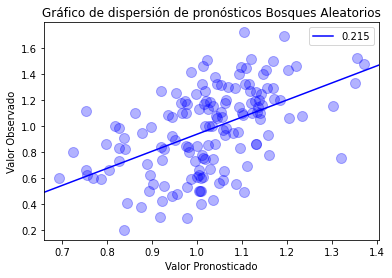

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión Bosques Aleatorios")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos Bosques Aleatorios")
plt.legend()
plt.show()

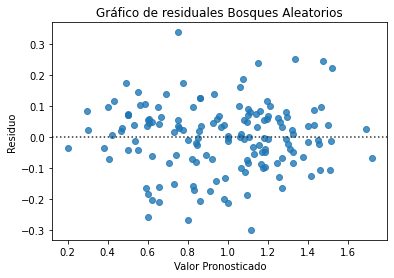

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales Bosques Aleatorios")
plt.show()

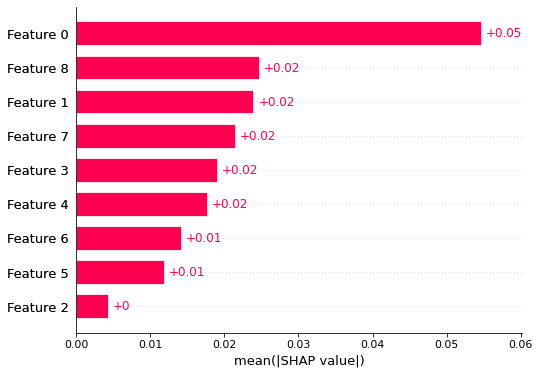

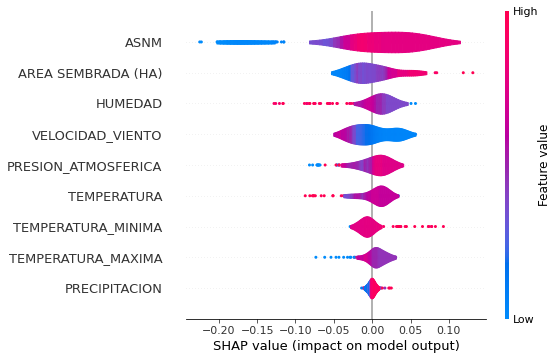

In [ ]:
# Shap Values
explainer = shap.TreeExplainer(regressor, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

Support Vector Regression

In [ ]:
from sklearn.svm import SVR
regressor_svr = SVR()

In [ ]:
#Encontrando los mejores hiperparámetros para el modelo
# param_grid = { 'kernel':['linear','rbf','sigmoid'],
#               'gamma': ['scale', 'auto'],
#               'C': [0.01,0.1,1.0,10,100,1000],
#               }
# g_search = GridSearchCV(estimator =regressor_svr, param_grid = param_grid, cv = 5, n_jobs = 1, verbose = 0, scoring = "r2")
# g_search.fit(X_train, Y_train);
# print("Los mejores parámetros son: ","\n", g_search.best_params_)

In [ ]:
CV = []
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10

for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = SVR(kernel="rbf", gamma ="auto", C=0.1).fit(X_train, Y_train)

    #  Cross Validation Score
    cv_regressor = cross_val_score(estimator = regressor, X = X_train, y = Y_train, cv = 5)

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)

    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
            
    CV.append(cv_regressor.mean())
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)

    s=s+1
    
    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

In [ ]:
# Guardando las repeticiones en un pandas dataframe
metricssvr=pd.DataFrame({'cv_svr':CV,
                        'r2_score_svr_train':R2train,
                        'r2_score_svr_test':R2test,
                        'mse_svr':MSE,
                        'rmse_svr':RMSE,
                        'mae_svr':MAE,
                        'mape_svr':MAPE})
metricssvr

,cv_svr,r2_score_svr_train,r2_score_svr_test,mse_svr,rmse_svr,mae_svr,mape_svr
0,0.138798,0.243750,0.124589,0.092826,0.304674,0.248866,0.356378
1,0.095561,0.216694,0.225499,0.077501,0.278389,0.220305,0.271782
2,0.135824,0.226645,0.177519,0.087701,0.296143,0.239839,0.375008
3,0.154627,0.282098,0.095859,0.109457,0.330842,0.240745,0.311110
4,0.131911,0.245821,0.134840,0.106579,0.326465,0.238045,0.341635
5,0.148219,0.262827,0.143523,0.076769,0.277072,0.228014,0.285467
6,0.124747,0.238508,0.132965,0.082797,0.287744,0.230640,0.311127
7,0.144121,0.244299,0.192851,0.055891,0.236413,0.189563,0.233295
8,0.164764,0.282682,0.096931,0.155961,0.394919,0.279610,0.419067
9,0.162828,0.256550,0.102524,0.079879,0.282630,0.230567,0.317895


In [ ]:
metricssvr.to_csv('repeticiones svr.csv', encoding = 'utf-8-sig') 
files.download('repeticiones svr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.2255


<Figure size 432x288 with 0 Axes>

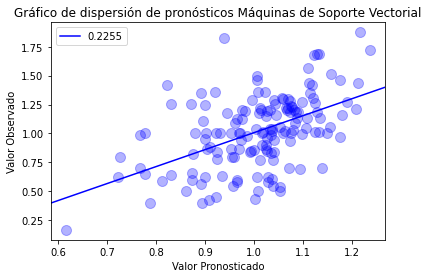

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión Máquinas de Soporte Vectorial")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos Máquinas de Soporte Vectorial")
plt.legend()
plt.show()

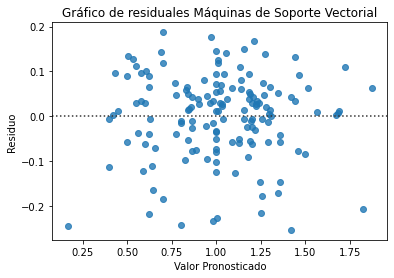

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales Máquinas de Soporte Vectorial")
plt.show()

Exact explainer: 151it [03:36,  1.48s/it]


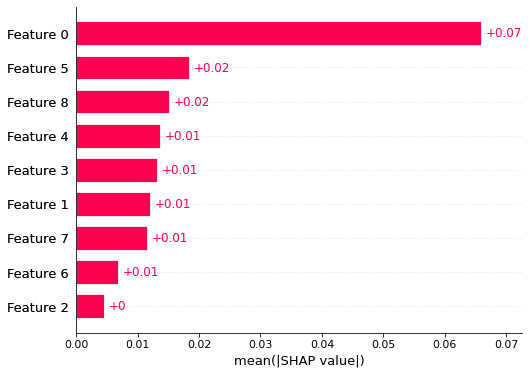

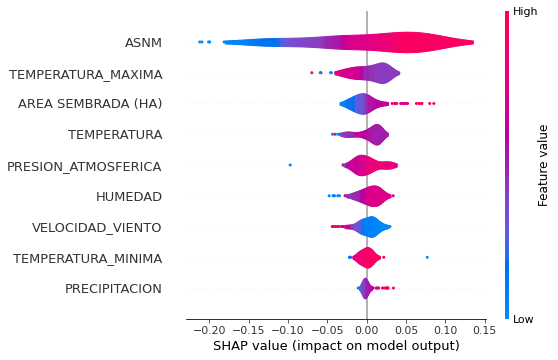

In [ ]:
# Shap Values
explainer = shap.Explainer(regressor.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Deep Learning Models**

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization

***Multilayer Perceptron***

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 30)                1950      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
 dense_4 (Dense)             (None, 5)                 105       
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 10)                6

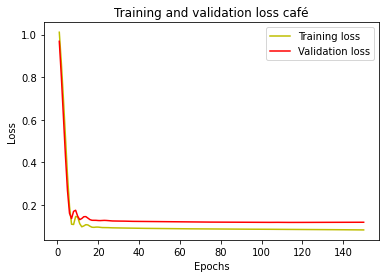

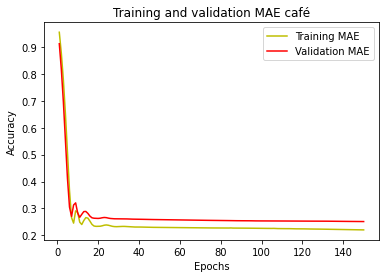

In [ ]:
with tf.device('/device:GPU:0'):
    model1 = Sequential()
    model1.add(Dense(128,input_dim=9,activation='sigmoid'))
    model1.add(Dense(64, activation='relu'))
    model1.add(Dense(30,activation='relu'))
    model1.add(Dense(20,activation='relu'))
    model1.add(Dense(5,activation='relu'))
    model1.add(Dense(5,activation='relu'))
    model1.add(Dense(10,activation='relu'))
    model1.add(Dense(15,activation='relu'))
    model1.add(Dense(5,activation='relu'))
    model1.add(Dense(1,activation='linear'))
    model1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
    model1.summary()
    history = model1.fit(X_train,Y_train,epochs=150,validation_split=0.2,batch_size=220, verbose=1, shuffle=False)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Training loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Training and validation loss café')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['mae']
    val_acc = history.history['val_mae']
    plt.plot(epochs,acc,'y',label='Training MAE')
    plt.plot(epochs,val_acc,'r',label='Validation MAE')
    plt.title('Training and validation MAE café')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10
for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = model1

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)

    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
            
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)
    
    s=s+1

    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor

5/5 [==============================] - 0s 3ms/step


In [ ]:
CV = []
s=10
for i in range(10):
    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    with tf.device('/device:GPU:0'):
      def create_network():
        model1 = Sequential()
        model1.add(Dense(128,input_dim=9,activation='sigmoid'))
        model1.add(Dense(64, activation='relu'))
        model1.add(Dense(30,activation='relu'))
        model1.add(Dense(20,activation='relu'))
        model1.add(Dense(5,activation='relu'))
        model1.add(Dense(5,activation='relu'))
        model1.add(Dense(10,activation='relu'))
        model1.add(Dense(15,activation='relu'))
        model1.add(Dense(5,activation='relu'))
        model1.add(Dense(1,activation='linear'))
        model1.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
        return model1
    # Envolver el modelo de Keras para que pueda ser utilizado por Sklearn
    neural_network = KerasRegressor(build_fn= create_network,epochs=150,validation_split=0.2,batch_size=220, verbose=1, shuffle=False) 
    # Cross Validation Score
    cv_regressor =cross_val_score(neural_network, X = X_train, y = Y_train, cv = 5,scoring='r2',n_jobs=1)
    CV.append(cv_regressor.mean())
    s=s+1

Epoch 1/150
2/2 [==============================] - 1s 264ms/step - loss: 1.0993 - mae: 0.9897 - val_loss: 1.1498 - val_mae: 1.0359
Epoch 2/150
2/2 [==============================] - 0s 29ms/step - loss: 1.0774 - mae: 0.9785 - val_loss: 1.1254 - val_mae: 1.0241
Epoch 3/150
2/2 [==============================] - 0s 32ms/step - loss: 1.0536 - mae: 0.9663 - val_loss: 1.0966 - val_mae: 1.0100
Epoch 4/150
2/2 [==============================] - 0s 28ms/step - loss: 1.0256 - mae: 0.9518 - val_loss: 1.0629 - val_mae: 0.9932
Epoch 5/150
2/2 [==============================] - 0s 31ms/step - loss: 0.9927 - mae: 0.9343 - val_loss: 1.0233 - val_mae: 0.9731
Epoch 6/150
2/2 [==============================] - 0s 29ms/step - loss: 0.9543 - mae: 0.9136 - val_loss: 0.9789 - val_mae: 0.9500
Epoch 7/150
2/2 [==============================] - 0s 29ms/step - loss: 0.9114 - mae: 0.8900 - val_loss: 0.9287 - val_mae: 0.9232
Epoch 8/150
2/2 [==============================] - 0s 33ms/step - loss: 0.8622 - mae: 0.8

1/1 [==============================] - 0s 129ms/step
Epoch 1/150
2/2 [==============================] - 1s 249ms/step - loss: 0.8693 - mae: 0.8760 - val_loss: 0.6823 - val_mae: 0.7644
Epoch 2/150
2/2 [==============================] - 0s 32ms/step - loss: 0.6943 - mae: 0.7702 - val_loss: 0.5058 - val_mae: 0.6419
Epoch 3/150
2/2 [==============================] - 0s 29ms/step - loss: 0.5103 - mae: 0.6414 - val_loss: 0.3376 - val_mae: 0.5047
Epoch 4/150
2/2 [==============================] - 0s 31ms/step - loss: 0.3380 - mae: 0.4991 - val_loss: 0.1994 - val_mae: 0.3757
Epoch 5/150
2/2 [==============================] - 0s 28ms/step - loss: 0.1984 - mae: 0.3681 - val_loss: 0.1126 - val_mae: 0.2868
Epoch 6/150
2/2 [==============================] - 0s 34ms/step - loss: 0.1150 - mae: 0.2711 - val_loss: 0.1030 - val_mae: 0.2473
Epoch 7/150
2/2 [==============================] - 0s 32ms/step - loss: 0.1110 - mae: 0.2526 - val_loss: 0.1583 - val_mae: 0.3049
Epoch 8/150
2/2 [===================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 41ms/step - loss: 0.0923 - mae: 0.2363 - val_loss: 0.1568 - val_mae: 0.2739
Epoch 60/150
2/2 [==============================] - 0s 38ms/step - loss: 0.0922 - mae: 0.2361 - val_loss: 0.1567 - val_mae: 0.2736
Epoch 61/150
2/2 [==============================] - 0s 39ms/step - loss: 0.0921 - mae: 0.2359 - val_loss: 0.1565 - val_mae: 0.2733
Epoch 62/150
2/2 [==============================] - 0s 63ms/step - loss: 0.0920 - mae: 0.2358 - val_loss: 0.1563 - val_mae: 0.2731
Epoch 63/150
2/2 [==============================] - 0s 55ms/step - loss: 0.0920 - mae: 0.2357 - val_loss: 0.1562 - val_mae: 0.2731
Epoch 64/150
2/2 [==============================] - 0s 40ms/step - loss: 0.0919 - mae: 0.2356 - val_loss: 0.1561 - val_mae: 0.2730
Epoch 65/150
2/2 [==============================] - 0s 42ms/step - loss: 0.0918 - mae: 0.2355 - val_loss: 0.1560 - val_mae: 0.2729
Epoch 66/150
2/2 [===========================

In [ ]:
# Guardando las repeticiones en un pandas dataframe
metricsmlp=pd.DataFrame({'cv_mlp':CV,
                        'r2_score_mlp_train':R2train,
                        'r2_score_mlp_test':R2test,
                        'mse_mlp':MSE,
                        'rmse_mlp':RMSE,
                        'mae_mlp':MAE,
                        'mape_mlp':MAPE})
metricsmlp

,cv_mlp,r2_score_mlp_train,r2_score_mlp_test,mse_mlp,rmse_mlp,mae_mlp,mape_mlp
0,-0.952728,0.125211,0.103479,0.095065,0.308326,0.253009,0.361614
1,-0.666849,0.093008,0.243447,0.075705,0.275145,0.223140,0.266562
2,-1.314516,0.120867,0.127013,0.093086,0.305100,0.249780,0.376775
3,-1.935502,0.163848,-0.002733,0.121392,0.348414,0.258993,0.335481
4,0.049839,0.137170,0.080768,0.113240,0.336512,0.253872,0.358635
5,0.038492,0.132589,0.099593,0.080706,0.284089,0.237554,0.301210
6,0.060169,0.137151,0.073664,0.088459,0.297421,0.237794,0.328723
7,-0.847845,0.130384,0.112237,0.061473,0.247938,0.198610,0.240356
8,-1.075118,0.137665,0.102450,0.155008,0.393711,0.280613,0.433272
9,0.091317,0.167292,-0.066352,0.094910,0.308075,0.250045,0.348962


In [ ]:
metricsmlp.to_csv('repeticiones mlp.csv', encoding = 'utf-8-sig') 
files.download('repeticiones mlp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Mejor R2 test: %.4f" % (r2_score(obs,pred)))

Mejor R2 test: 0.2434


<Figure size 432x288 with 0 Axes>

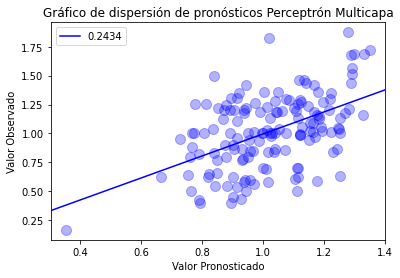

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos Perceptrón Multicapa")
plt.legend()
plt.show()

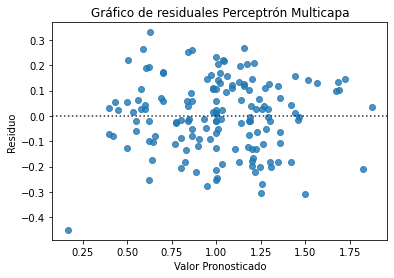

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales Perceptrón Multicapa")
plt.show()

31/31 [==============================] - 0s 3ms/step


Exact explainer:   1%|▏         | 2/150 [00:00<?, ?it/s]

32/32 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 4/150 [00:16<05:42,  2.35s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 5/150 [00:22<08:44,  3.62s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 6/150 [00:27<09:45,  4.07s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 7/150 [00:32<10:45,  4.52s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 8/150 [00:37<11:23,  4.81s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 9/150 [00:43<11:45,  5.00s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 10/150 [00:47<11:14,  4.82s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 11/150 [00:52<10:56,  4.73s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 12/150 [00:57<11:21,  4.94s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:   9%|▊         | 13/150 [01:02<11:35,  5.07s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 14/150 [01:08<11:44,  5.18s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 15/150 [01:13<11:48,  5.25s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 16/150 [01:19<11:50,  5.30s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  11%|█▏        | 17/150 [01:24<11:48,  5.33s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 18/150 [01:30<11:50,  5.38s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 19/150 [01:35<11:46,  5.39s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 20/150 [01:41<11:55,  5.51s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 21/150 [01:46<11:22,  5.29s/it]

32/32 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▍        | 22/150 [01:50<10:58,  5.15s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 23/150 [01:55<10:36,  5.01s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 24/150 [02:00<10:42,  5.10s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 25/150 [02:06<10:49,  5.20s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 26/150 [02:11<10:52,  5.26s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 27/150 [02:16<10:23,  5.07s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▊        | 28/150 [02:21<10:29,  5.16s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 29/150 [02:27<10:29,  5.21s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 30/150 [02:31<10:11,  5.09s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 31/150 [02:37<10:17,  5.19s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 32/150 [02:42<10:18,  5.25s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 33/150 [02:47<09:57,  5.11s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 34/150 [02:52<10:02,  5.19s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 35/150 [02:58<10:03,  5.25s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 36/150 [03:03<10:03,  5.29s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 37/150 [03:09<10:01,  5.32s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 38/150 [03:13<09:32,  5.11s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 39/150 [03:19<09:35,  5.19s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 40/150 [03:24<09:37,  5.25s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 41/150 [03:29<09:37,  5.30s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 42/150 [03:34<09:00,  5.00s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 43/150 [03:38<08:42,  4.88s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 44/150 [03:44<08:54,  5.04s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 45/150 [03:49<08:59,  5.14s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 46/150 [03:54<08:42,  5.03s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 47/150 [03:58<08:26,  4.92s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 48/150 [04:03<08:17,  4.88s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 49/150 [04:08<08:10,  4.85s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 50/150 [04:13<07:57,  4.77s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 51/150 [04:18<08:11,  4.96s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 52/150 [04:23<08:06,  4.96s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 53/150 [04:28<08:15,  5.11s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 54/150 [04:34<08:17,  5.18s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 55/150 [04:39<08:18,  5.25s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 56/150 [04:44<08:01,  5.12s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 57/150 [04:49<08:02,  5.19s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▊      | 58/150 [04:55<08:03,  5.25s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 59/150 [05:00<07:50,  5.17s/it]

31/31 [==============================] - 0s 1ms/step


Exact explainer:  40%|████      | 60/150 [05:05<07:48,  5.20s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 61/150 [05:08<06:50,  4.62s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  41%|████▏     | 62/150 [05:14<07:06,  4.84s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 63/150 [05:19<07:13,  4.98s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 64/150 [05:24<07:16,  5.08s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 65/150 [05:28<06:25,  4.53s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 66/150 [05:33<06:39,  4.76s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 67/150 [05:36<05:53,  4.26s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 68/150 [05:41<06:14,  4.56s/it]

31/31 [==============================] - 0s 1ms/step


Exact explainer:  46%|████▌     | 69/150 [05:44<05:32,  4.11s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 70/150 [05:50<05:58,  4.48s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 71/150 [05:53<05:23,  4.09s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 72/150 [05:56<04:57,  3.82s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 73/150 [05:59<04:39,  3.63s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 74/150 [06:04<05:15,  4.15s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 75/150 [06:08<04:48,  3.85s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 76/150 [06:11<04:32,  3.68s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 77/150 [06:16<05:04,  4.16s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 78/150 [06:19<04:39,  3.89s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 79/150 [06:23<04:20,  3.68s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 80/150 [06:26<04:09,  3.56s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 81/150 [06:29<04:01,  3.49s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 82/150 [06:35<04:35,  4.06s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 83/150 [06:40<04:56,  4.43s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 84/150 [06:43<04:27,  4.05s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 85/150 [06:48<04:48,  4.44s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 86/150 [06:52<04:19,  4.06s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 87/150 [06:55<03:58,  3.78s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 88/150 [07:00<04:23,  4.25s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 89/150 [07:03<03:58,  3.91s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 90/150 [07:06<03:38,  3.65s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 91/150 [07:09<03:25,  3.48s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  61%|██████▏   | 92/150 [07:15<03:53,  4.02s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 93/150 [07:20<04:12,  4.42s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 94/150 [07:23<03:47,  4.06s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 95/150 [07:27<03:33,  3.89s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 96/150 [07:30<03:19,  3.70s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 97/150 [07:35<03:42,  4.20s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 98/150 [07:41<03:55,  4.53s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 99/150 [07:44<03:34,  4.21s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 100/150 [07:47<03:17,  3.96s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 101/150 [07:53<03:33,  4.36s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 102/150 [07:56<03:13,  4.02s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 103/150 [07:59<03:01,  3.87s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 104/150 [08:05<03:18,  4.32s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 105/150 [08:10<03:28,  4.63s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 106/150 [08:13<03:05,  4.22s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 107/150 [08:17<02:48,  3.91s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  72%|███████▏  | 108/150 [08:22<03:02,  4.34s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 109/150 [08:27<03:09,  4.63s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 110/150 [08:33<03:13,  4.83s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 111/150 [08:38<03:14,  4.99s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 112/150 [08:41<02:49,  4.46s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 113/150 [08:44<02:32,  4.12s/it]

31/31 [==============================] - 0s 1ms/step


Exact explainer:  76%|███████▌  | 114/150 [08:50<02:40,  4.46s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 115/150 [08:53<02:21,  4.05s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 116/150 [08:57<02:17,  4.04s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 117/150 [09:02<02:26,  4.45s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 118/150 [09:06<02:13,  4.17s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 119/150 [09:09<02:01,  3.91s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 120/150 [09:12<01:52,  3.76s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 121/150 [09:18<02:02,  4.23s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 122/150 [09:21<01:50,  3.96s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 123/150 [09:26<01:57,  4.36s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 124/150 [09:32<02:01,  4.67s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 125/150 [09:35<01:47,  4.32s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 126/150 [09:39<01:37,  4.08s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 127/150 [09:42<01:28,  3.84s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 128/150 [09:46<01:22,  3.75s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 129/150 [09:51<01:28,  4.21s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 130/150 [09:56<01:30,  4.54s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 131/150 [10:02<01:30,  4.77s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 132/150 [10:07<01:29,  4.95s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 133/150 [10:10<01:14,  4.41s/it]

31/31 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 134/150 [10:15<01:14,  4.68s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 135/150 [10:19<01:04,  4.27s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 136/150 [10:24<01:04,  4.58s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 137/150 [10:29<01:02,  4.81s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 138/150 [10:35<00:59,  4.98s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 139/150 [10:40<00:56,  5.11s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 140/150 [10:44<00:45,  4.59s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 141/150 [10:49<00:43,  4.81s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 142/150 [10:54<00:39,  4.95s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 143/150 [10:58<00:31,  4.51s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 144/150 [11:03<00:28,  4.75s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 145/150 [11:08<00:24,  4.92s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 146/150 [11:14<00:20,  5.06s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 147/150 [11:17<00:13,  4.66s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 148/150 [11:23<00:09,  4.87s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 149/150 [11:28<00:05,  5.02s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer: 100%|██████████| 150/150 [11:31<00:00,  4.49s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer: 151it [11:37,  4.68s/it]


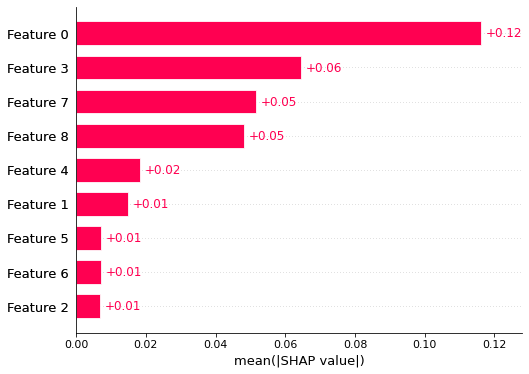

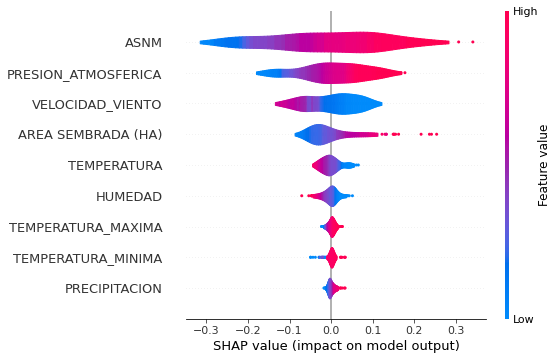

In [ ]:
# Shap Values
explainer = shap.Explainer(model1.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test, plot_type='violin',feature_names=columns.columns)

**Recurrent Neural Network: Long Short Term Memory (LSTM)**

In [ ]:
X_train=X_train.reshape(597,1,9)
Y_train=Y_train.reshape(597,1,1)
X_test=X_test.reshape(150,1,9)
Y_test=Y_test.reshape(150,1,1)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 10)             800       
                                                                 
 dense_510 (Dense)           (None, 1, 5)              55        
                                                                 
 lstm_1 (LSTM)               (None, 10)                640       
                                                                 
 dense_511 (Dense)           (None, 5)                 55        
                                                                 
 dense_512 (Dense)           (None, 10)                60        
                                                                 
 dense_513 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1,621
Trainable params: 1,621
Non-train

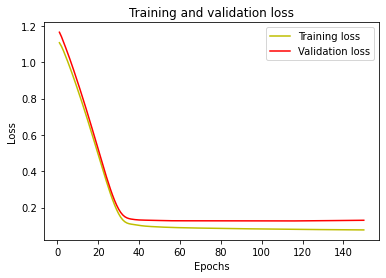

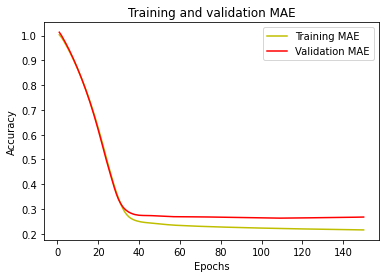

In [ ]:
from keras.layers import LSTM
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(LSTM(10,input_shape=(1,9),return_sequences=True, activation='relu'))
  model.add(Dense(5,activation='relu'))
  model.add(LSTM(10,activation='relu'))
  model.add(Dense(5,activation='relu'))
  model.add(Dense(10,activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer="Adam", loss="mse",metrics=["mae"])
  model.summary()
  history = model.fit(X_train,Y_train,validation_split=0.2,epochs=150, batch_size=220, verbose=1, shuffle=False)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1,len(loss)+1)
  plt.plot(epochs,loss,'y',label='Training loss')
  plt.plot(epochs,val_loss,'r',label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = history.history['mae']
  val_acc = history.history['val_mae']
  plt.plot(epochs,acc,'y',label='Training MAE')
  plt.plot(epochs,val_acc,'r',label='Validation MAE')
  plt.title('Training and validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
R2train = []
R2test = []
MSE = []
RMSE = []
MAE = []
MAPE = []
pred=np.array(0)
obs=np.array(0)
s=10
for i in range(10):

    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 

    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    X_train=X_train.reshape(597,1,9)
    Y_train=Y_train.reshape(597,1,1)
    X_test=X_test.reshape(150,1,9)
    Y_test=Y_test.reshape(150,1,1)

    #Llamamos nuestra función regresora con los mejores hiperparámetros
    regressor = model

    # Predicting R2 Score the Train set results
    y_pred_regressor_train = regressor.predict(X_train).reshape(597,1)
    Y_train=Y_train.reshape(597,1)
    r2_score_regressor_train = r2_score(Y_train, y_pred_regressor_train)

    # Predicting R2 Score the Test set results
    y_pred_regressor_test = regressor.predict(X_test).reshape(150,1)
    Y_test=Y_test.reshape(150,1)
    r2_score_regressor_test = r2_score(Y_test, y_pred_regressor_test)

    # Predicting MSE the Test set results
    mse_regressor = mean_squared_error(Y_test, y_pred_regressor_test)

    # Predicting RMSE the Test set results
    rmse_regressor = mean_squared_error(Y_test, y_pred_regressor_test, squared=False)

    # Predicting MAE the Test set results
    mae_regressor = mean_absolute_error(Y_test, y_pred_regressor_test)

    # Predicting MAPE the Test set results
    mape_regressor = mean_absolute_percentage_error(Y_test, y_pred_regressor_test)
            
   
    R2train.append(r2_score_regressor_train)
    R2test.append(r2_score_regressor_test)
    MSE.append(mse_regressor)
    RMSE.append(rmse_regressor)
    MAE.append(mae_regressor)
    MAPE.append(mape_regressor)
    
    s=s+1

    if r2_score_regressor_test.mean() >= max(R2test):
        pred =  regressor.predict(X_test)
        obs = Y_test
        X_Test = X_test
        Y_Test = Y_test
        model =  regressor
        

5/5 [==============================] - 0s 4ms/step


In [ ]:
CV = []
s=10
for i in range(10): 
    # Train, Test, Split
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=s) 
    
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)     
    
    X_train=X_train.reshape(597,1,9)
    Y_train=Y_train.reshape(597,1,1)
    X_test=X_test.reshape(150,1,9)
    Y_test=Y_test.reshape(150,1,1)
    #Llamamos nuestra función regresora con los mejores hiperparámetros
    with tf.device('/device:GPU:0'):
      def rnn_model():
        model = Sequential()
        model.add(LSTM(10,input_shape=(1,9),return_sequences=True, activation='relu'))
        model.add(Dense(5,activation='relu'))
        model.add(LSTM(10,activation='relu'))
        model.add(Dense(5,activation='relu'))
        model.add(Dense(10,activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer="Adam", loss="mse",metrics=["mae"])
        return model
    # Envolver el modelo de Keras para que pueda ser utilizado por Sklearn
    rnn_network = KerasRegressor(build_fn= rnn_model,validation_split=0.2,batch_size=220,epochs=150, verbose=1, shuffle=False)
    # Cross Validation Score
    
    Y_train=Y_train.reshape(597,1)
    
    cv_regressor =cross_val_score(rnn_network, X = X_train, y = Y_train, cv = 5,scoring='r2',n_jobs=1,error_score="raise")
    CV.append(cv_regressor.mean())
    s=s+1

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 59ms/step - loss: 0.1995 - mae: 0.3740 - val_loss: 0.2604 - val_mae: 0.4060
Epoch 60/150
2/2 [==============================] - 0s 43ms/step - loss: 0.1902 - mae: 0.3641 - val_loss: 0.2492 - val_mae: 0.3942
Epoch 61/150
2/2 [==============================] - 0s 62ms/step - loss: 0.1824 - mae: 0.3556 - val_loss: 0.2392 - val_mae: 0.3828
Epoch 62/150
2/2 [==============================] - 0s 51ms/step - loss: 0.1757 - mae: 0.3482 - val_loss: 0.2302 - val_mae: 0.3718
Epoch 63/150
2/2 [==============================] - 0s 40ms/step - loss: 0.1696 - mae: 0.3411 - val_loss: 0.2220 - val_mae: 0.3622
Epoch 64/150
2/2 [==============================] - 0s 40ms/step - loss: 0.1639 - mae: 0.3346 - val_loss: 0.2147 - val_mae: 0.3536
Epoch 65/150
2/2 [==============================] - 0s 38ms/step - loss: 0.1586 - mae: 0.3287 - val_loss: 0.2082 - val_mae: 0.3466
Epoch 66/150
2/2 [===========================

In [ ]:
# Guardando las 100 repeticiones en un pandas dataframe
metricslstm=pd.DataFrame({'cv_lstm':CV,
                        'r2_score_lstm_train':R2train,
                        'r2_score_lstm_test':R2test,
                        'mse_lstm':MSE,
                        'rmse_lstm':RMSE,
                        'mae_lstm':MAE,
                        'mape_lstm':MAPE})
metricslstm

,cv_lstm,r2_score_lstm_train,r2_score_lstm_test,mse_lstm,rmse_lstm,mae_lstm,mape_lstm
0,0.044827,0.138491,0.100497,0.095381,0.308838,0.244415,0.343401
1,0.007709,0.100039,0.216260,0.078425,0.280045,0.223771,0.286349
2,0.028166,0.115057,0.145438,0.091121,0.301863,0.244870,0.382789
3,0.107952,0.128070,0.040561,0.116151,0.340810,0.252321,0.334888
4,-0.054713,0.152197,0.020158,0.120707,0.347429,0.256101,0.354304
5,0.096531,0.141934,0.107218,0.080023,0.282883,0.232194,0.290389
6,0.054750,0.138342,0.061778,0.089595,0.299323,0.234861,0.314839
7,0.015222,0.131979,0.115935,0.061217,0.247421,0.196126,0.232722
8,0.116990,0.127089,0.172992,0.142825,0.377923,0.270202,0.416100
9,0.086095,0.184253,-0.144485,0.101864,0.319162,0.255594,0.343199


In [ ]:
metricslstm.to_csv('repeticiones lstm.csv', encoding = 'utf-8-sig') 
files.download('repeticiones lstm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

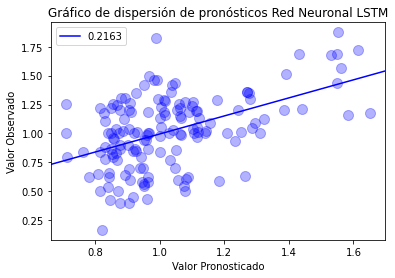

In [ ]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Valor Pronosticado")
plt.ylabel("Valor Observado")
plt.title("Gráfico de dispersión de pronósticos Red Neuronal LSTM")
plt.legend()
plt.show()

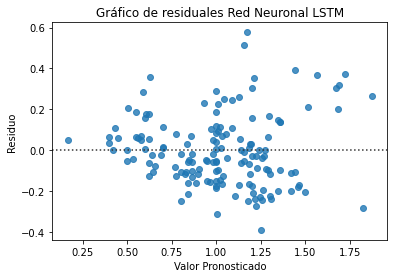

In [ ]:
sns.residplot(obs,pred)
plt.xlabel("Valor Pronosticado")
plt.ylabel("Residuo")
plt.title("Gráfico de residuales Red Neuronal LSTM")
plt.show()

**Comparación de modelos**

***Valores promedio de las repeticiones por modelo***

In [ ]:
# DataFrame valores promedio de las repeticiones
modelsmean = [('Linear Regression',metricslr['mape_lr'].mean(),metricslr['mae_lr'].mean(), metricslr['mse_lr'].mean(), metricslr['rmse_lr'].mean(), metricslr['r2_score_lr_train'].mean(), metricslr['r2_score_lr_test'].mean(), metricslr['cv_lr'].mean()),
              ('Decision Tree',metricsdt['mape_dt'].mean(),metricsdt['mae_dt'].mean(), metricsdt['mse_dt'].mean(), metricsdt['rmse_dt'].mean(), metricsdt['r2_score_dt_train'].mean(), metricsdt['r2_score_dt_test'].mean(), metricsdt['cv_dt'].mean()),
              ('Support Vector Regression',metricssvr['mape_svr'].mean(),metricssvr['mae_svr'].mean(), metricssvr['mse_svr'].mean(), metricssvr['rmse_svr'].mean(), metricssvr['r2_score_svr_train'].mean(), metricssvr['r2_score_svr_test'].mean(), metricssvr['cv_svr'].mean()),
              ('XGBoost',metricsxgbr['mape_xgbr'].mean(),metricsxgbr['mae_xgbr'].mean(), metricsxgbr['mse_xgbr'].mean(), metricsxgbr['rmse_xgbr'].mean(), metricsxgbr['r2_score_xgbr_train'].mean(), metricsxgbr['r2_score_xgbr_test'].mean(), metricsxgbr['cv_xgbr'].mean()), 
              ('Random Forest',metricsrf['mape_rf'].mean(),metricsrf['mae_rf'].mean(), metricsrf['mse_rf'].mean(), metricsrf['rmse_rf'].mean(), metricsrf['r2_score_rf_train'].mean(), metricsrf['r2_score_rf_test'].mean(), metricsrf['cv_rf'].mean()),
              ('Multilayer Perceptron',metricsmlp['mape_mlp'].mean(),metricsmlp['mae_mlp'].mean(), metricsmlp['mse_mlp'].mean(), metricsmlp['rmse_mlp'].mean(), metricsmlp['r2_score_mlp_train'].mean(), metricsmlp['r2_score_mlp_test'].mean(), metricsmlp['cv_mlp'].mean()),
              ('LSTM Recurrent Network',metricslstm['mape_lstm'].mean(),metricslstm['mae_lstm'].mean(), metricslstm['mse_lstm'].mean(), metricslstm['rmse_lstm'].mean(), metricslstm['r2_score_lstm_train'].mean(), metricslstm['r2_score_lstm_test'].mean(), metricslstm['cv_lstm'].mean()),
              ]
predictmean = pd.DataFrame(data = modelsmean, columns=['Model','MAPE','MAE','MSE', 'RMSE', 'R2 (train)', 'R2 (test)', 'Cross-Validation'])
predictmean

,Model,MAPE,MAE,MSE,RMSE,R2 (train),R2 (test),Cross-Validation
0,Linear Regression,0.342543,0.250284,0.101468,0.316175,0.116108,0.054134,0.058791
1,Decision Tree,0.346575,0.245551,0.102171,0.317318,0.091591,0.048512,0.064062
2,Support Vector Regression,0.322276,0.234619,0.092536,0.301529,0.249988,0.142710,0.140140
3,XGBoost,0.326338,0.235512,0.097313,0.310176,0.937780,0.084297,0.184670
4,Random Forest,0.320088,0.229184,0.091264,0.300222,0.676665,0.145175,0.227087
5,Multilayer Perceptron,0.335159,0.244341,0.097905,0.310473,0.134518,0.087357,-0.655274
6,LSTM Recurrent Network,0.329898,0.241046,0.097731,0.310570,0.135745,0.083635,0.050353


In [112]:
predictmean.to_csv('predictmeancafe.csv', encoding = 'utf-8-sig') 
files.download('predictmeancafe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Mejores valores de las repeticiones por modelo***

In [ ]:
# DataFrame mejores valores de las repeticiones
modelsbest = [('Linear Regression',metricslr['mape_lr'].min(),metricslr['mae_lr'].min(), metricslr['mse_lr'].min(), metricslr['rmse_lr'].min(), metricslr['r2_score_lr_train'].max(), metricslr['r2_score_lr_test'].max(), metricslr['cv_lr'].max()),
              ('Decision Tree',metricsdt['mape_dt'].min(),metricsdt['mae_dt'].min(), metricsdt['mse_dt'].min(), metricsdt['rmse_dt'].min(), metricsdt['r2_score_dt_train'].max(), metricsdt['r2_score_dt_test'].max(), metricsdt['cv_dt'].max()),
              ('Support Vector Regression',metricssvr['mape_svr'].min(),metricssvr['mae_svr'].min(), metricssvr['mse_svr'].min(), metricssvr['rmse_svr'].min(), metricssvr['r2_score_svr_train'].max(), metricssvr['r2_score_svr_test'].max(), metricssvr['cv_svr'].max()),
              ('XGBoost',metricsxgbr['mape_xgbr'].min(),metricsxgbr['mae_xgbr'].min(), metricsxgbr['mse_xgbr'].min(), metricsxgbr['rmse_xgbr'].min(), metricsxgbr['r2_score_xgbr_train'].max(), metricsxgbr['r2_score_xgbr_test'].max(), metricsxgbr['cv_xgbr'].max()), 
              ('Random Forest',metricsrf['mape_rf'].min(),metricsrf['mae_rf'].min(), metricsrf['mse_rf'].min(), metricsrf['rmse_rf'].min(), metricsrf['r2_score_rf_train'].max(), metricsrf['r2_score_rf_test'].max(), metricsrf['cv_rf'].max()),
              ('Multilayer Perceptron',metricsmlp['mape_mlp'].min(),metricsmlp['mae_mlp'].min(), metricsmlp['mse_mlp'].min(), metricsmlp['rmse_mlp'].min(), metricsmlp['r2_score_mlp_train'].max(), metricsmlp['r2_score_mlp_test'].max(), metricsmlp['cv_mlp'].max()),
              ('LSTM Recurrent Network',metricslstm['mape_lstm'].min(),metricslstm['mae_lstm'].min(), metricslstm['mse_lstm'].min(), metricslstm['rmse_lstm'].min(), metricslstm['r2_score_lstm_train'].max(), metricslstm['r2_score_lstm_test'].max(), metricslstm['cv_lstm'].max()),
              ]
predictbest = pd.DataFrame(data = modelsbest, columns=['Model','MAPE','MAE','MSE', 'RMSE', 'R2 (train)', 'R2 (test)', 'Cross-Validation'])
predictbest

,Model,MAPE,MAE,MSE,RMSE,R2 (train),R2 (test),Cross-Validation
0,Linear Regression,0.247624,0.205048,0.063126,0.251249,0.153109,0.159675,0.112953
1,Decision Tree,0.243438,0.199159,0.063147,0.251291,0.113736,0.088062,0.100435
2,Support Vector Regression,0.233295,0.189563,0.055891,0.236413,0.282682,0.225499,0.164764
3,XGBoost,0.247754,0.204211,0.074299,0.272579,0.942826,0.180022,0.283426
4,Random Forest,0.244629,0.193787,0.065528,0.255984,0.701573,0.214987,0.286731
5,Multilayer Perceptron,0.240356,0.198610,0.061473,0.247938,0.167292,0.243447,0.091317
6,LSTM Recurrent Network,0.232722,0.196126,0.061217,0.247421,0.184253,0.216260,0.116990


***Desviación estándar de las repeticiones por modelo***

In [ ]:
# DataFrame desviación estándar de las repeticiones
modelsdesvest = [('Linear Regression',metricslr['mape_lr'].std(),metricslr['mae_lr'].std(), metricslr['mse_lr'].std(), metricslr['rmse_lr'].std(), metricslr['r2_score_lr_train'].std(), metricslr['r2_score_lr_test'].std(), metricslr['cv_lr'].std()),
                ('Decision Tree',metricsdt['mape_dt'].std(),metricsdt['mae_dt'].std(), metricsdt['mse_dt'].std(), metricsdt['rmse_dt'].std(), metricsdt['r2_score_dt_train'].std(), metricsdt['r2_score_dt_test'].std(), metricsdt['cv_dt'].std()),
                ('Support Vector Regression',metricssvr['mape_svr'].std(),metricssvr['mae_svr'].std(), metricssvr['mse_svr'].std(), metricssvr['rmse_svr'].std(), metricssvr['r2_score_svr_train'].std(), metricssvr['r2_score_svr_test'].std(), metricssvr['cv_svr'].std()),
                ('XGBoost',metricsxgbr['mape_xgbr'].std(),metricsxgbr['mae_xgbr'].std(), metricsxgbr['mse_xgbr'].std(), metricsxgbr['rmse_xgbr'].std(), metricsxgbr['r2_score_xgbr_train'].std(), metricsxgbr['r2_score_xgbr_test'].std(), metricsxgbr['cv_xgbr'].std()), 
                ('Random Forest',metricsrf['mape_rf'].std(),metricsrf['mae_rf'].std(), metricsrf['mse_rf'].std(), metricsrf['rmse_rf'].std(), metricsrf['r2_score_rf_train'].std(), metricsrf['r2_score_rf_test'].std(), metricsrf['cv_rf'].std()),
                ('Multilayer Perceptron',metricsmlp['mape_mlp'].std(),metricsmlp['mae_mlp'].std(), metricsmlp['mse_mlp'].std(), metricsmlp['rmse_mlp'].std(), metricsmlp['r2_score_mlp_train'].std(), metricsmlp['r2_score_mlp_test'].std(), metricsmlp['cv_mlp'].std()),
                ('LSTM Recurrent Network',metricslstm['mape_lstm'].std(),metricslstm['mae_lstm'].std(), metricslstm['mse_lstm'].std(), metricslstm['rmse_lstm'].std(), metricslstm['r2_score_lstm_train'].std(), metricslstm['r2_score_lstm_test'].std(), metricslstm['cv_lstm'].std()),
                ]
predictdesvest = pd.DataFrame(data = modelsdesvest, columns=['Model','MAPE','MAE','MSE', 'RMSE', 'R2 (train)', 'R2 (test)', 'Cross-Validation'])
predictdesvest

,Model,MAPE,MAE,MSE,RMSE,R2 (train),R2 (test),Cross-Validation
0,Linear Regression,0.053171,0.022066,0.026902,0.040846,0.018721,0.068218,0.036908
1,Decision Tree,0.060157,0.024785,0.026885,0.040552,0.011796,0.036796,0.025241
2,Support Vector Regression,0.053517,0.022644,0.027085,0.042377,0.021555,0.043425,0.020343
3,XGBoost,0.050299,0.018660,0.022647,0.035025,0.002231,0.095008,0.064285
4,Random Forest,0.047970,0.017579,0.022516,0.035454,0.014836,0.055493,0.030838
5,Multilayer Perceptron,0.055464,0.022081,0.026443,0.040975,0.021016,0.081081,0.701055
6,LSTM Recurrent Network,0.051999,0.020748,0.023694,0.037675,0.022428,0.099821,0.053543


***Gráficos validación cruzada promedio de las repeticiones por modelo***

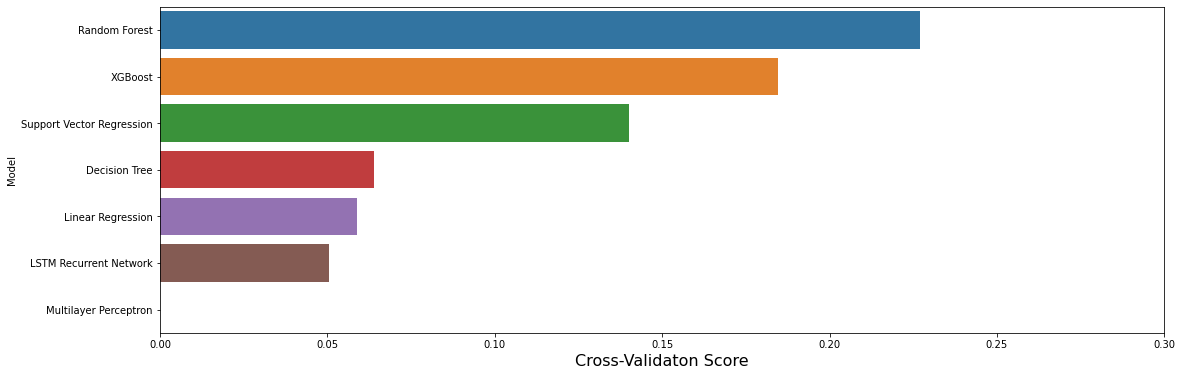

In [111]:
f, axe = plt.subplots(1,1, figsize=(18,6))
predictmean.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)
sns.barplot(x='Cross-Validation', y='Model', data = predictmean, ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,0.3)
plt.show()

***Gráficos R2 train y test promedio de las repeticiones por modelo***

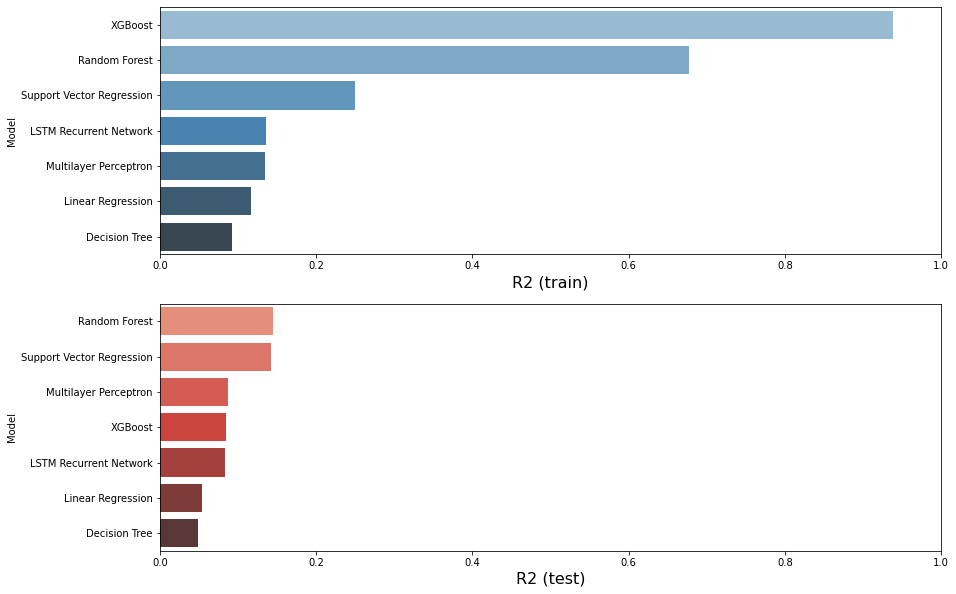

In [108]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predictmean.sort_values(by=['R2 (train)'], ascending=False, inplace=True)

sns.barplot(x='R2 (train)', y='Model', data = predictmean, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 (train)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1)

predictmean.sort_values(by=['R2 (test)'], ascending=False, inplace=True)

sns.barplot(x='R2 (test)', y='Model', data = predictmean, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 (test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1)

plt.show()

***ANOVA MAPE***

In [ ]:
# Primero se comprueba que el aprendizaje de los modelos siga un comportamiento normal (en la validación cruzada)
from scipy.stats import shapiro
my_data = [metricslr["mape_lr"],metricsdt["mape_dt"],metricssvr["mape_svr"],metricsxgbr["mape_xgbr"],metricsrf["mape_rf"],metricsmlp["mape_mlp"],metricslstm["mape_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],shapiro(i))
  pos=pos+1

LR ShapiroResult(statistic=0.979646623134613, pvalue=0.9632490277290344)
DT ShapiroResult(statistic=0.9786714911460876, pvalue=0.957663357257843)
SVR ShapiroResult(statistic=0.9901185035705566, pvalue=0.9969557523727417)
XGBR ShapiroResult(statistic=0.9527239203453064, pvalue=0.7007774114608765)
RF ShapiroResult(statistic=0.9583344459533691, pvalue=0.7667269110679626)
MLP ShapiroResult(statistic=0.972581684589386, pvalue=0.9136953949928284)
LSTM ShapiroResult(statistic=0.9805395007133484, pvalue=0.9679896235466003)


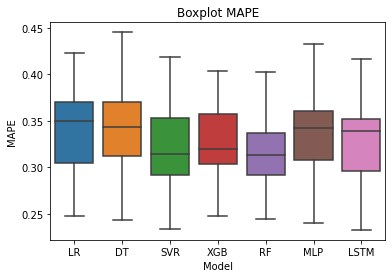

In [ ]:
# Los gráficos de boxplot también permitirán ver diferencias entre la distribución de las 100 repeticiones en la validación cruzada (entrenamiento)
models_cv = pd.DataFrame.from_dict({'LR': metricslr.mape_lr, 'DT': metricsdt.mape_dt,'SVR': metricssvr.mape_svr,'XGB': metricsxgbr.mape_xgbr,'RF': metricsrf.mape_rf,'MLP': metricsmlp.mape_mlp,'LSTM': metricslstm.mape_lstm}).melt()
models_cv=models_cv.rename(columns={"variable":"Modelo"})
sns.boxplot(x="Modelo", y="value",data=models_cv)
plt.xlabel("Model")
plt.ylabel("MAPE")
plt.title("Boxplot MAPE")
plt.show()

In [ ]:
# Aplicamos un test ANOVA para validar si existen diferencias significativas en el aprendizaje, es decir, si existen diferencias significativas entre la capacidad de generalización entre modelos
modelo = ols("value  ~ C(Modelo)", data=models_cv).fit()
anova = sm.stats.anova_lm(modelo)
print(anova)

             df    sum_sq   mean_sq         F    PR(>F)
C(Modelo)   6.0  0.006063  0.001011  0.355078  0.904323
Residual   63.0  0.179294  0.002846       NaN       NaN


***Gráficos RMSE promedio de las repeticiones***

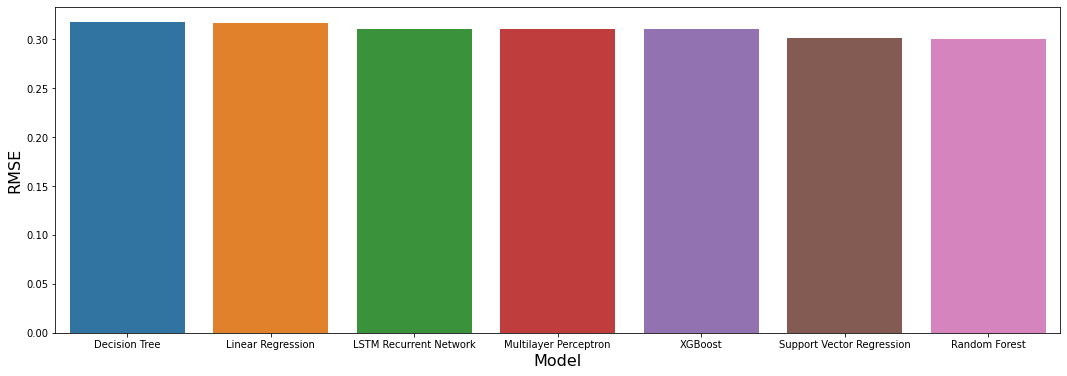

In [ ]:
predictmean.sort_values(by=['RMSE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)
plt.show()

***Gráficos MSE promedio de las repeticiones***

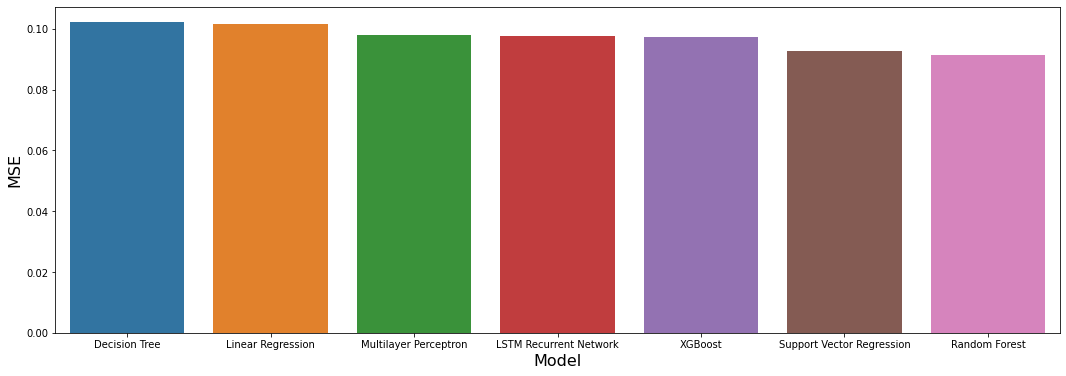

In [ ]:
predictmean.sort_values(by=['MSE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='MSE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('MSE', size=16)
plt.show()

***Gráficos MAE promedio de las repeticiones***

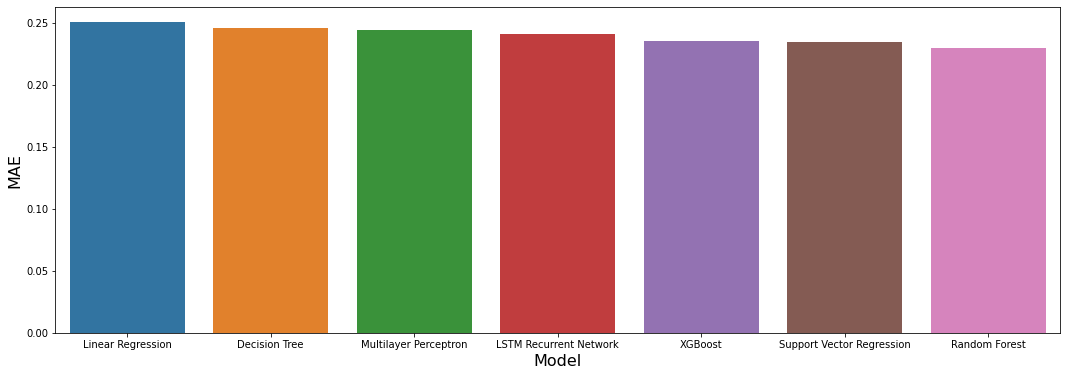

In [ ]:
predictmean.sort_values(by=['MAE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='MAE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('MAE', size=16)
plt.show()

***Gráficos MAPE promedio de las repeticiones***

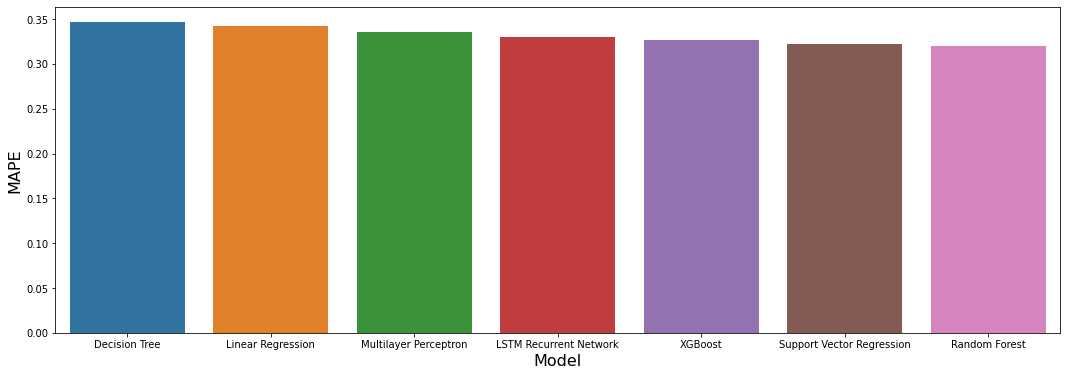

In [ ]:
predictmean.sort_values(by=['MAPE'], ascending=False, inplace=True)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='MAPE', data=predictmean, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('MAPE', size=16)
plt.show()

**Normalidad e intervalos de confianza para el ajuste y el error**

***Test de normalidad Normalidad para el ajuste en el conjunto de datos de prueba***

In [ ]:
from scipy.stats import shapiro
my_data = [metricslr["r2_score_lr_test"],metricsdt["r2_score_dt_test"],metricssvr["r2_score_svr_test"],metricsxgbr["r2_score_xgbr_test"],metricsrf["r2_score_rf_test"],metricsmlp["r2_score_mlp_test"],metricslstm["r2_score_lstm_test"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],shapiro(i))
  pos=pos+1

LR ShapiroResult(statistic=0.8943679928779602, pvalue=0.18980742990970612)
DT ShapiroResult(statistic=0.8914077877998352, pvalue=0.17587189376354218)
SVR ShapiroResult(statistic=0.9119452834129333, pvalue=0.2946219742298126)
XGBR ShapiroResult(statistic=0.8447158336639404, pvalue=0.05024528130888939)
RF ShapiroResult(statistic=0.9075124263763428, pvalue=0.2643376886844635)
MLP ShapiroResult(statistic=0.9064903259277344, pvalue=0.2577424943447113)
LSTM ShapiroResult(statistic=0.9162023067474365, pvalue=0.32636648416519165)


***Intervalos de confianza para el ajuste en el conjunto de datos de prueba***

In [ ]:
import scipy.stats as st
my_data = [metricslr["r2_score_lr_test"],metricsdt["r2_score_dt_test"],metricssvr["r2_score_svr_test"],metricsxgbr["r2_score_xgbr_test"],metricsrf["r2_score_rf_test"],metricsmlp["r2_score_mlp_test"],metricslstm["r2_score_lstm_test"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],st.t.interval(alpha=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)))
  pos=pos+1

LR (0.005334056731905561, 0.10293455810122276)
DT (0.022189945886374948, 0.07483446393139584)
SVR (0.11164565752343336, 0.17377387650944853)
XGBR (0.016332424874667628, 0.15226200609347473)
RF (0.10547745801269089, 0.18487183627475035)
MLP (0.029354980025776772, 0.14535839532823036)
LSTM (0.012227292406599102, 0.15504325972156402)


***Test de normalidad Normalidad para el MSE***


In [ ]:
from scipy.stats import shapiro
my_data = [metricslr["mse_lr"],metricsdt["mse_dt"],metricssvr["mse_svr"],metricsxgbr["mse_xgbr"],metricsrf["mse_rf"],metricsmlp["mse_mlp"],metricslstm["mse_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],shapiro(i))
  pos=pos+1

LR ShapiroResult(statistic=0.9182733297348022, pvalue=0.34277859330177307)
DT ShapiroResult(statistic=0.9069567918777466, pvalue=0.26073476672172546)
SVR ShapiroResult(statistic=0.8790936470031738, pvalue=0.12740102410316467)
XGBR ShapiroResult(statistic=0.8709308505058289, pvalue=0.10249325633049011)
RF ShapiroResult(statistic=0.8706762194633484, pvalue=0.10179588943719864)
MLP ShapiroResult(statistic=0.9311795234680176, pvalue=0.4595944285392761)
LSTM ShapiroResult(statistic=0.9739496111869812, pvalue=0.9248555302619934)


***Intervalos de confianza para el MSE***

In [ ]:
import scipy.stats as st
my_data = [metricslr["mse_lr"],metricsdt["mse_dt"],metricssvr["mse_svr"],metricsxgbr["mse_xgbr"],metricsrf["mse_rf"],metricsmlp["mse_mlp"],metricslstm["mse_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],st.t.interval(alpha=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)))
  pos=pos+1

LR (0.08222353525311496, 0.12071309677594791)
DT (0.08293838583456767, 0.12140264922064903)
SVR (0.07316076913271212, 0.11191145698892134)
XGBR (0.08111247679454636, 0.11351373279462879)
RF (0.075157186432647, 0.10737164406948903)
MLP (0.07898854664461752, 0.11682059971905054)
LSTM (0.08078119540212042, 0.11468082009914038)


***Test de normalidad Normalidad para el MAPE***

In [ ]:
from scipy.stats import shapiro
my_data = [metricslr["mape_lr"],metricsdt["mape_dt"],metricssvr["mape_svr"],metricsxgbr["mape_xgbr"],metricsrf["mape_rf"],metricsmlp["mape_mlp"],metricslstm["mape_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],shapiro(i))
  pos=pos+1

LR ShapiroResult(statistic=0.979646623134613, pvalue=0.9632490277290344)
DT ShapiroResult(statistic=0.9786714911460876, pvalue=0.957663357257843)
SVR ShapiroResult(statistic=0.9901185035705566, pvalue=0.9969557523727417)
XGBR ShapiroResult(statistic=0.9527239203453064, pvalue=0.7007774114608765)
RF ShapiroResult(statistic=0.9583344459533691, pvalue=0.7667269110679626)
MLP ShapiroResult(statistic=0.972581684589386, pvalue=0.9136953949928284)
LSTM ShapiroResult(statistic=0.9805395007133484, pvalue=0.9679896235466003)


***Intervalos de confianza para el MAPE***

In [ ]:
import scipy.stats as st
my_data = [metricslr["mape_lr"],metricsdt["mape_dt"],metricssvr["mape_svr"],metricsxgbr["mape_xgbr"],metricsrf["mape_rf"],metricsmlp["mape_mlp"],metricslstm["mape_lstm"]]
nombres = ["LR","DT","SVR","XGBR","RF","MLP","LSTM"]
pos=0
for i in my_data:
  print(nombres[pos],st.t.interval(alpha=0.95, df=len(i)-1, loc=np.mean(i), scale=st.sem(i)))
  pos=pos+1

LR (0.3045070001143904, 0.38057970556851534)
DT (0.30354137415195276, 0.3896086830441536)
SVR (0.2839923015822577, 0.36056052240090436)
XGBR (0.29035664571192327, 0.3623199125261349)
RF (0.2857720702650988, 0.3544036048851949)
MLP (0.29548231272497527, 0.3748360422321403)
LSTM (0.29269970317626004, 0.3670960325112035)
